# Defining and Detecting Interactions
## Distances between Bees

In [3]:
import os
import math
from collections import Counter

import numpy as np
import scipy as sc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from bb_binary import FrameContainer, Repository

matplotlib.rc("figure", figsize=(12, 6))
sns.set_style('white')

repo = Repository('/Users/alexa/Projects/bees-sna/2015/')

In [4]:
all_distances = [] # list of all distances (distance, bee1, bee2, frameID, angle)

for frame, container in repo.iter_frames():
    positions = []
    for detection in frame.detectionsUnion.detectionsDP:
        positions.append((detection.xpos, detection.ypos, detection.decodedId, detection.zRotation))

    # Calculate distances for this frame
    for i in range(len(positions)-2):
        bee1 = positions[i]
        for j in range(i+1, len(positions)-1):
            bee2 = positions[j]
            distX = bee2[0] - bee1[0]
            distY = bee2[1] - bee1[1]
            dist = math.sqrt(distX*distX + distY*distY)
            angle = math.degrees(abs(bee2[3] - bee1[3]))
            if angle > 180:
                angle = 360 - angle
            all_distances.append((dist, bee1, bee2, frame.frameIdx, angle))

Why is the ID (# global unique id of the frame) always 0?

Number of all distances over all frames

In [5]:
print(len(all_distances))

3861138


Minimum and Maximal Distance between bees


In [6]:
list = [x[0] for x in all_distances]
dists = np.array(list)
print("Minimum distance: {}".format(np.min(dists)))
print("Maximum distance: {}".format(np.max(dists)))
print("Mean distance: {}".format(np.mean(dists)))
print("Median distance: {}".format(np.median(dists)))
print("STD: {}".format(np.std(dists)))

Minimum distance: 60.0
Maximum distance: 4451.604317546653
Mean distance: 1299.6812630502675
Median distance: 1232.1625298628355
STD: 678.3693703837363


## Histogramm of Distances

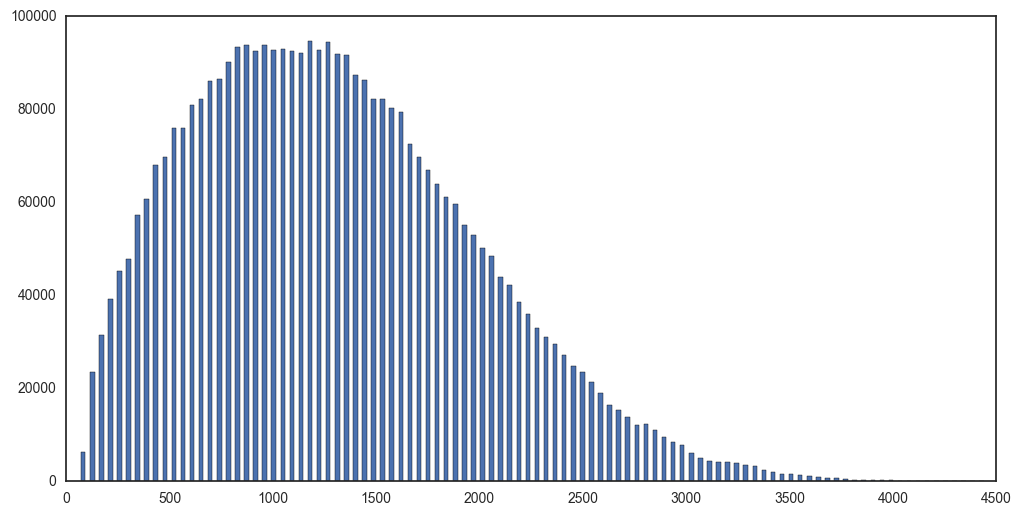

In [7]:
hist, bins = np.histogram(dists, bins=100)
width = 0.5* (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

## What value to use for close distance?
How to choose the right distance? How to calculate it?

In [8]:
max = 1000
list = []

for i in range(0, max, 10): 
    list.append(len([x for x in all_distances if x[0] <= i]))

[0, 0, 0, 0, 0, 0, 1, 141, 850, 2369, 4708, 8562, 13896, 19694, 25364, 31039, 37773, 45196, 52531, 59870, 67383, 76310, 86100, 95927, 105495, 114985, 125155, 135649, 146137, 156245, 166481, 178171, 190212, 202389, 214688, 226770, 240023, 253909, 268124, 282204, 295784, 309909, 324936, 340397, 355615, 370236, 386063, 402488, 419257, 435259, 450917, 467424, 484774, 501989, 519588, 536405, 554115, 571825, 589728, 607544, 624308, 642497, 661534, 680863, 699494, 717298, 735902, 755703, 775298, 794437, 813189, 832520, 852875, 873156, 892974, 911698, 931276, 951873, 972448, 992809, 1012756, 1033474, 1055491, 1077351, 1099022, 1119323, 1140779, 1162883, 1184494, 1205205, 1225638, 1247005, 1268966, 1290420, 1311472, 1331450, 1352835, 1374696, 1396414, 1418086]


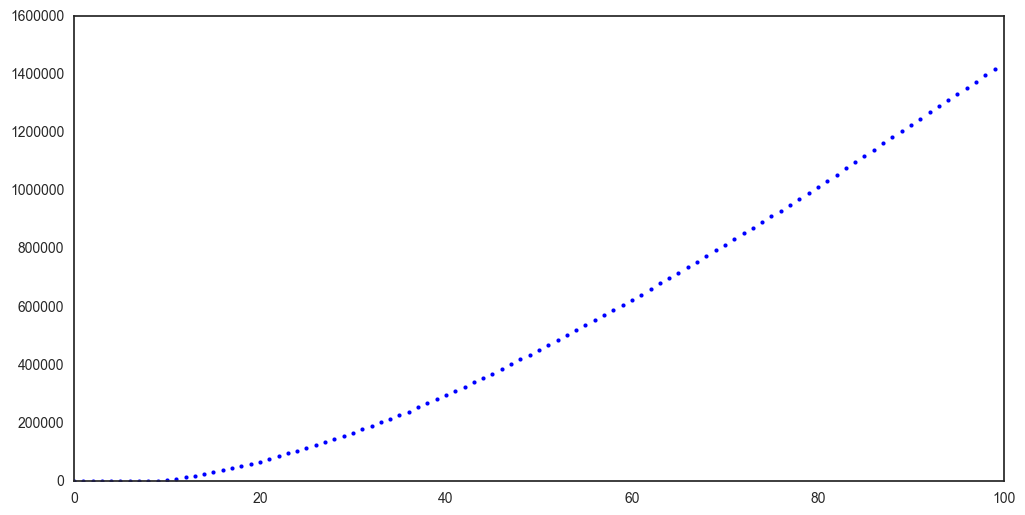

In [9]:
print(list)
plt.plot(list, 'bo', markersize=3)
plt.show()

In [10]:
max = 100
l = [x for x in all_distances if x[0] <= max]
print("Number of distances: {}".format(len(l)))

Number of distances: 4708


## Calculating IDs for close bees
What IDs are involved? For each succesive timeframe, do the same bees stay together?
First calculate all the IDs, those who can not be translated for sure (63) are just thrown away.

In [11]:
# Calculating ids with delta 63 (just for testing)
def getId(delta, id):

    c = 0
    number = 0
    for i in range(len(id)):
        if (id[i] <= 0 + delta):
            c = c + 1
        if (id[i] >= 255 - delta):
            c = c + 1
            number = number + 2**i
    # Add detected number in decimal
    if c == 12:
        return number
    else:
        return -1
    
delta = 63

id_list = [x for x in l if ((getId(delta, x[1][2]) > -1) and (getId(delta, x[2][2])) > -1)]    

In [12]:
print(id_list[0])
print("Number of good ids: {}".format(len(id_list)))

(83.64807230295268, (62, 2912, <capnp list reader [0, 255, 0, 255, 255, 255, 0, 255, 0, 0, 255, 0]>, -2.084784746170044), (101, 2838, <capnp list reader [255, 0, 0, 255, 0, 255, 255, 255, 0, 0, 0, 0]>, 0.7521601319313049), 0, 162.54496822646308)
Number of good ids: 3227


In [13]:
percent = ((100*len(id_list))/len(l))
print("Percent of bees with good ID: {}%".format(percent))

Percent of bees with good ID: 68.5429056924384%


So we lost kind of a lot of bees when calculating the IDs in decimal.

In [14]:
bees = [] #IDbee1, IDbee2, bee1, bee2, frameID, distance, angle
for x in id_list:
    bees.append((getId(delta, x[1][2]), getId(delta, x[2][2]), x[1], x[2], x[3], x[0], x[4]))
    

In [15]:
print(bees[2])
#print(id_list[2])

(647, 184, (749, 2325, <capnp list reader [255, 255, 255, 0, 1, 0, 0, 255, 0, 255, 0, 0]>, 2.946261405944824), (812, 2249, <capnp list reader [0, 0, 0, 255, 255, 255, 0, 255, 0, 0, 0, 0]>, -2.882028102874756), 0, 98.71676655968832, 26.063609364262447)


# Angles - zRotation between pairs of Bees
## Look at the angles
* What angles? Range|min|max|mean|median
* Whats the distribution?
* How many bees over 70 deg?

In [16]:
angles = [x[6] for x in bees]
a = np.array(angles)
print("Minimum angle: {}".format(np.min(a)))
print("Maximum angle: {}".format(np.max(a)))
print("Mean angle: {}".format(np.mean(a)))
print("Median angles: {}".format(np.median(a)))
print("STD: {}".format(np.std(a)))

Minimum angle: 0.0062427929013916545
Maximum angle: 179.9922188206736
Mean angle: 84.74643251684822
Median angles: 69.96095147971278
STD: 61.76911355580001


In [17]:
print(bees[0])

(1210, 233, (62, 2912, <capnp list reader [0, 255, 0, 255, 255, 255, 0, 255, 0, 0, 255, 0]>, -2.084784746170044), (101, 2838, <capnp list reader [255, 0, 0, 255, 0, 255, 255, 255, 0, 0, 0, 0]>, 0.7521601319313049), 0, 83.64807230295268, 162.54496822646308)


## Angle Distribution

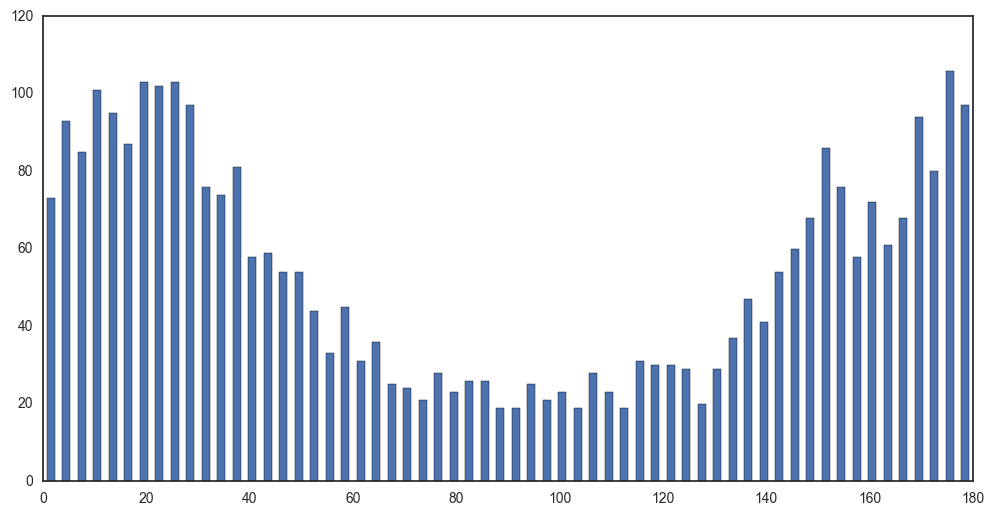

In [18]:
hist, bins = np.histogram(angles, bins=60)
width = 0.5* (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

## How many degrees over 70 degree?
Why 70? Why not 90?

I think trophallaxis can happen between more than two bees.

http://www.michiganbees.org/2012/trophallaxis/

# Frequency of Interaction
* Are there any ID combinations which occur very often?
* How often is often?

In [19]:
from collections import Counter

d = []
for elem in bees:
    d.append(frozenset([elem[0], elem[1]]))

In [20]:
print(len(d))
print(len(Counter(d)))
# print(Counter(d))

3227
840


In [21]:
countings = [value for key,value in Counter(d).items()]

c = np.array(countings)
print("Minimum countings: {}".format(np.min(c)))
print("Maximum countings: {}".format(np.max(c)))
print("Mean countings: {}".format(np.mean(c)))
print("Median countings: {}".format(np.median(c)))
print("STD: {}".format(np.std(c)))


Minimum countings: 1
Maximum countings: 95
Mean countings: 3.841666666666667
Median countings: 1.5
STD: 7.7554851300982195


In [22]:
sc.stats.itemfreq(countings)

array([[  1, 420],
       [  2, 144],
       [  3,  74],
       [  4,  47],
       [  5,  27],
       [  6,  17],
       [  7,  15],
       [  8,  13],
       [  9,   9],
       [ 10,  10],
       [ 11,  10],
       [ 12,  10],
       [ 13,   5],
       [ 14,   4],
       [ 15,   3],
       [ 16,   5],
       [ 17,   1],
       [ 19,   2],
       [ 21,   2],
       [ 22,   1],
       [ 23,   5],
       [ 24,   1],
       [ 25,   1],
       [ 32,   1],
       [ 35,   3],
       [ 36,   1],
       [ 40,   1],
       [ 43,   1],
       [ 45,   1],
       [ 49,   1],
       [ 50,   1],
       [ 54,   1],
       [ 84,   1],
       [ 90,   1],
       [ 95,   1]])

## Those bees who meet kind of often, where do they meet.
Plot for highest three pairs.

frozenset({3168, 3356}) 49
frozenset({2826, 3491}) 43
frozenset({889, 2379}) 32
frozenset({889, 3098}) 45
frozenset({3097, 2826}) 35
frozenset({2379, 374}) 84
frozenset({1123, 263}) 40
frozenset({3491, 1463}) 35
frozenset({1475, 3356}) 54
frozenset({2507, 2446}) 50
frozenset({2754, 2004}) 36
frozenset({2379, 2507}) 95
frozenset({3098, 2507}) 35
frozenset({2826, 1123}) 90


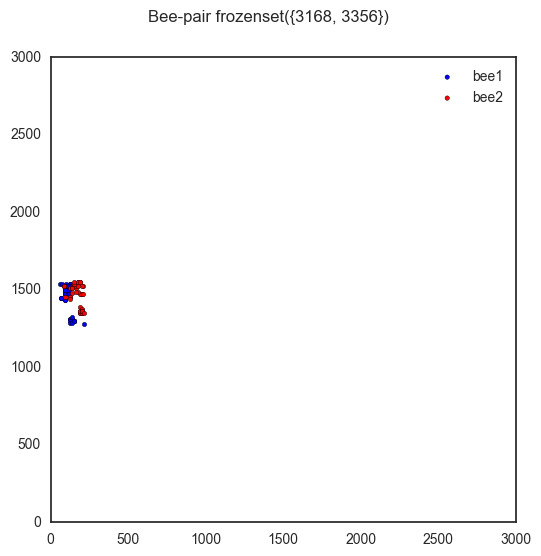

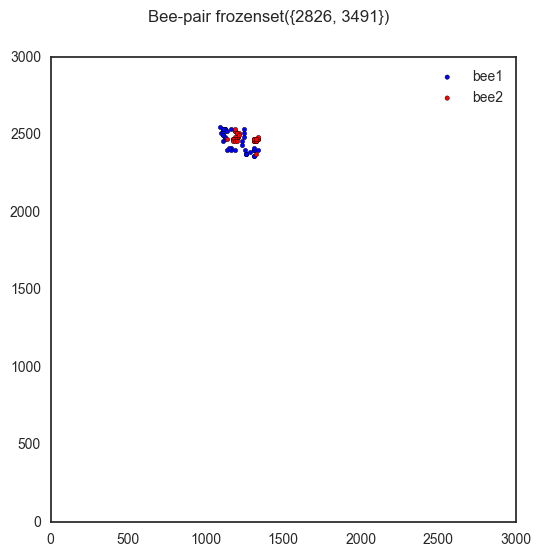

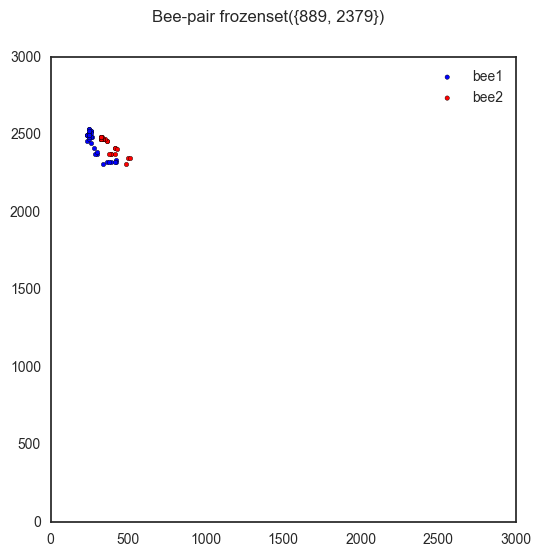

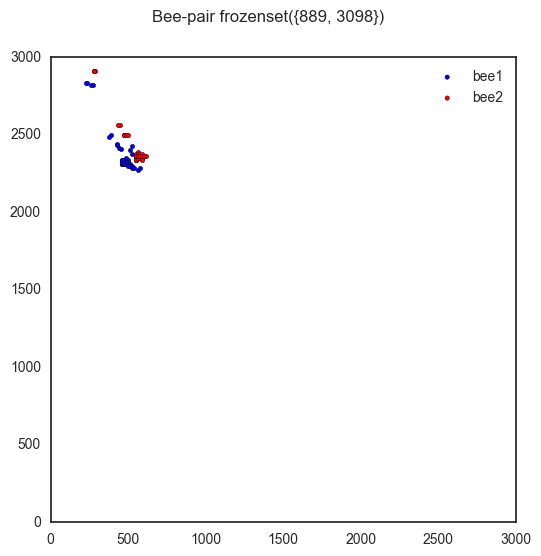

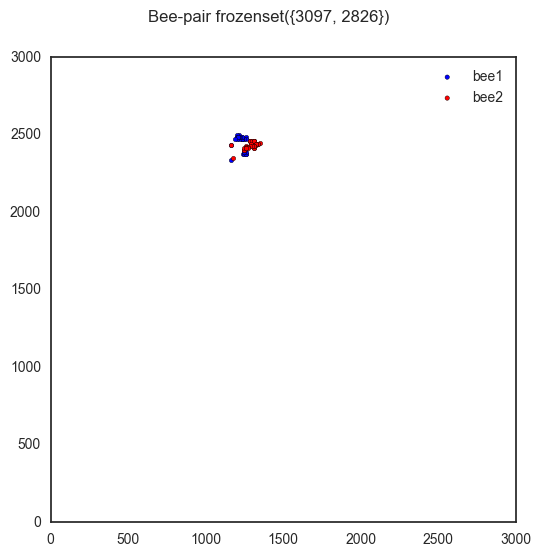

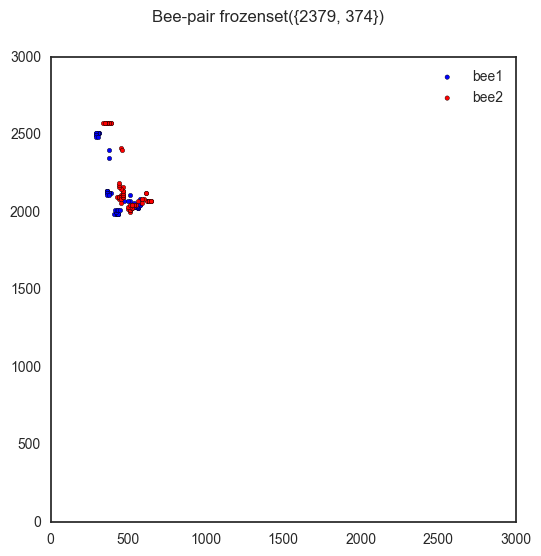

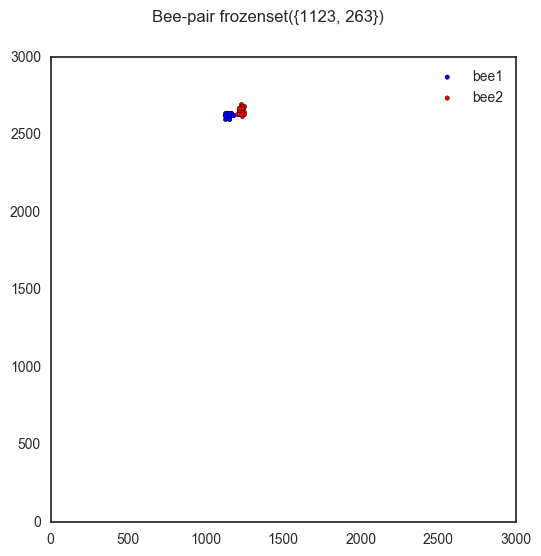

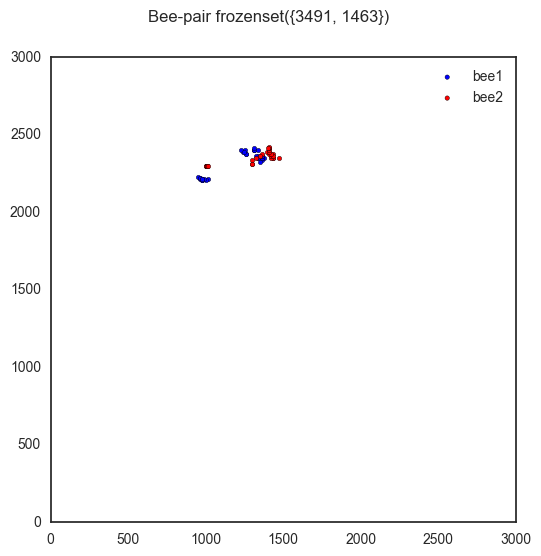

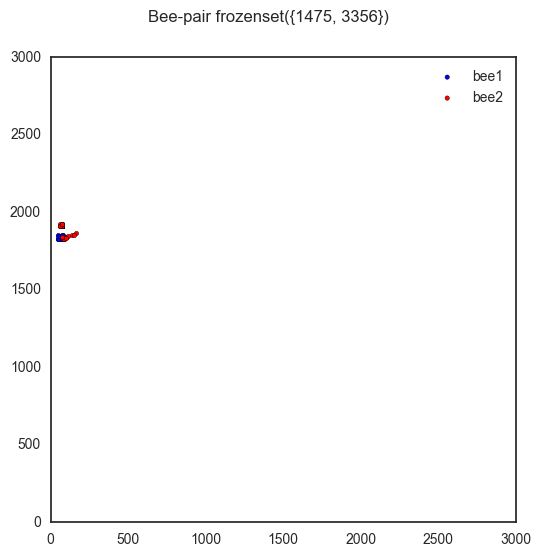

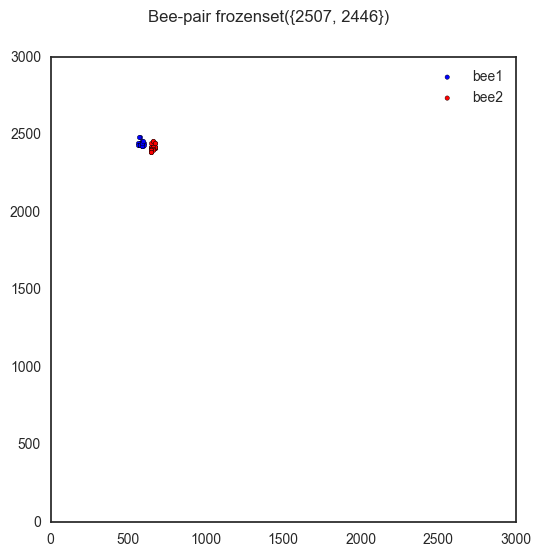

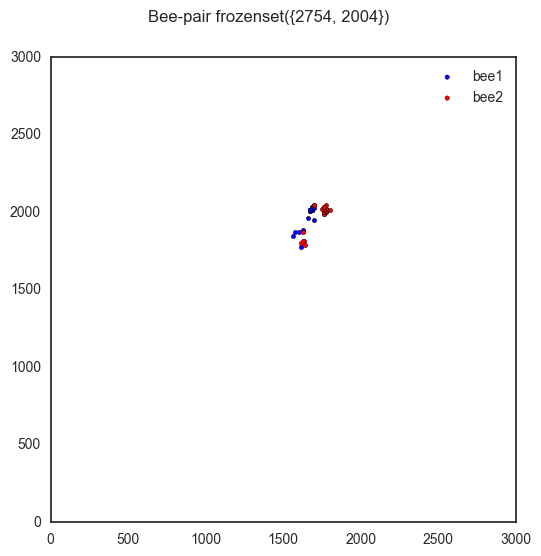

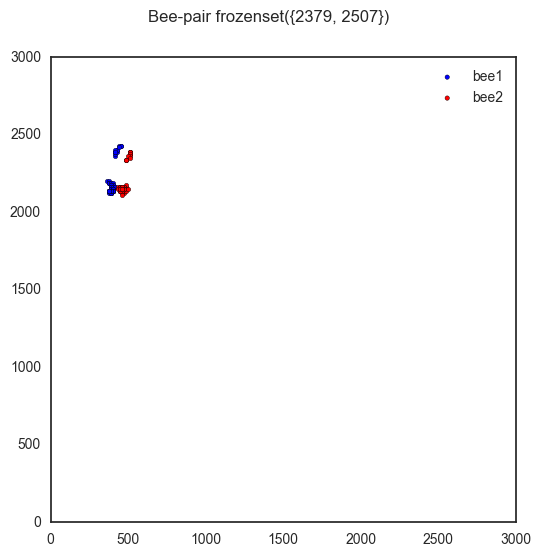

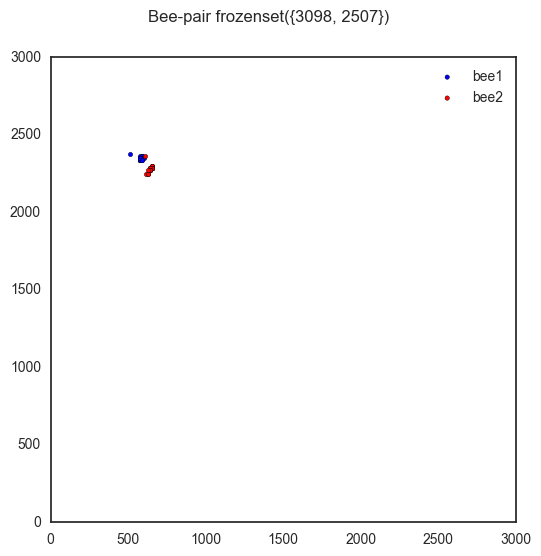

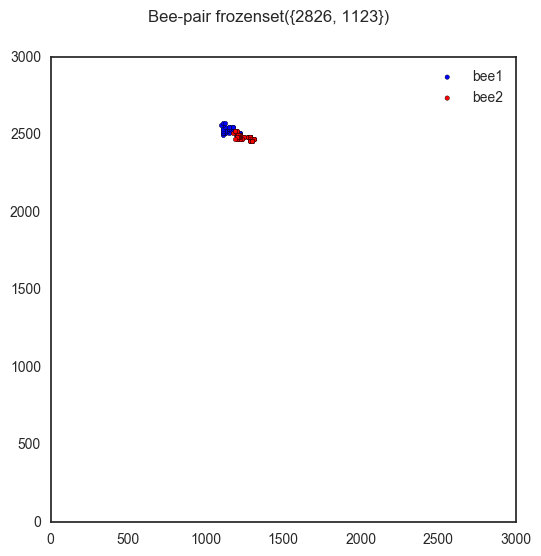

In [23]:
pairs = []
for key, value in Counter(d).items():
    if(value > 30):
        print(key, value)
        pairs.append(key)

for p in pairs:
    interactions = [x for x in bees if(x[0] in p and x[1] in p)]
    bees1 = [(x[2][0],x[2][1]) for x in interactions]
    bees2 = [(x[3][0],x[3][1]) for x in interactions]
    
    # plotten
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(*zip(*bees1), s=10, c='b', marker="o", label='bee1')
    ax1.scatter(*zip(*bees2), s=10, c='r', marker="o", label='bee2')
    plt.legend(loc='upper right');
    plt.xlim(0, 3000)
    plt.ylim(0, 3000)
    plt.axes().set_aspect('equal')
    plt.suptitle('Bee-pair {}'.format(p), fontsize=12)
    plt.show()

## Whats the angle of those bee pairs?

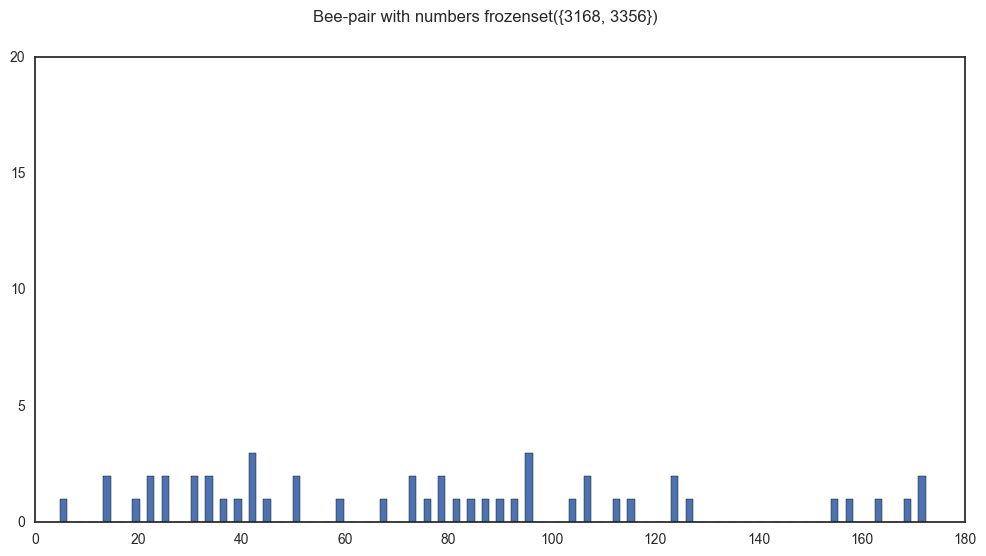

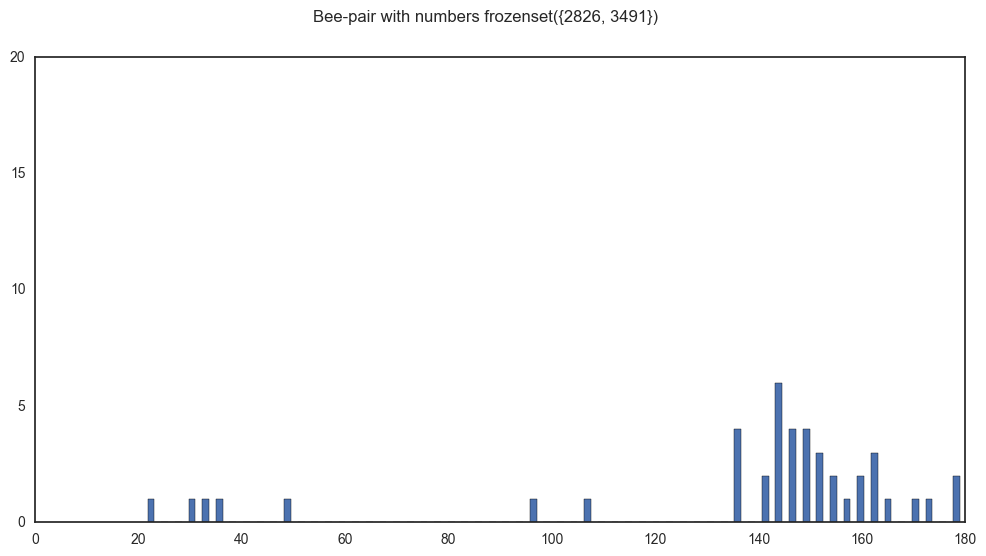

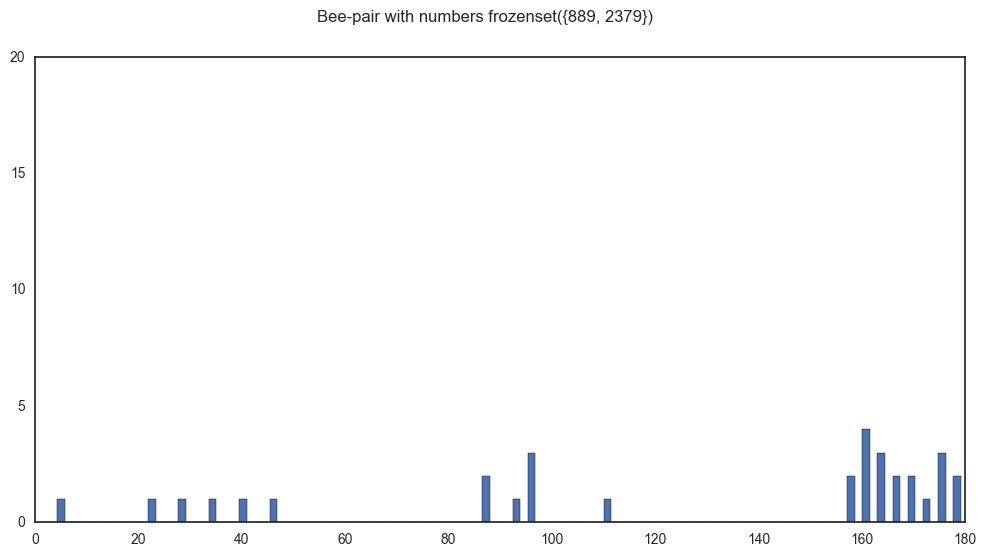

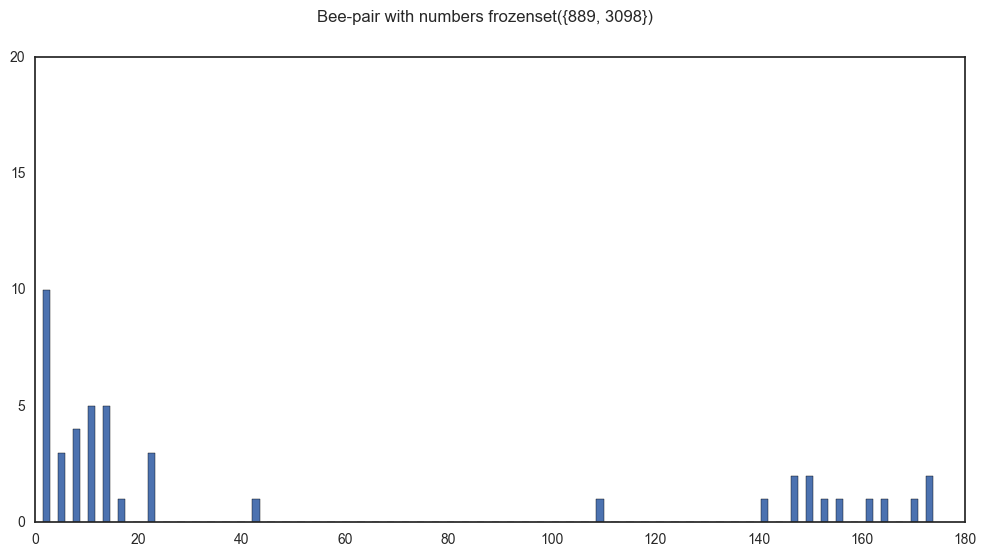

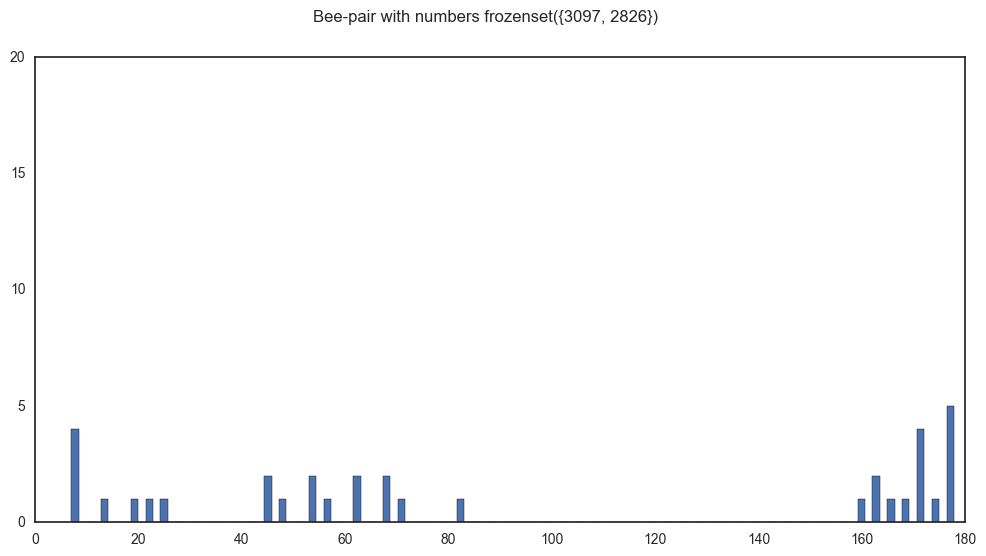

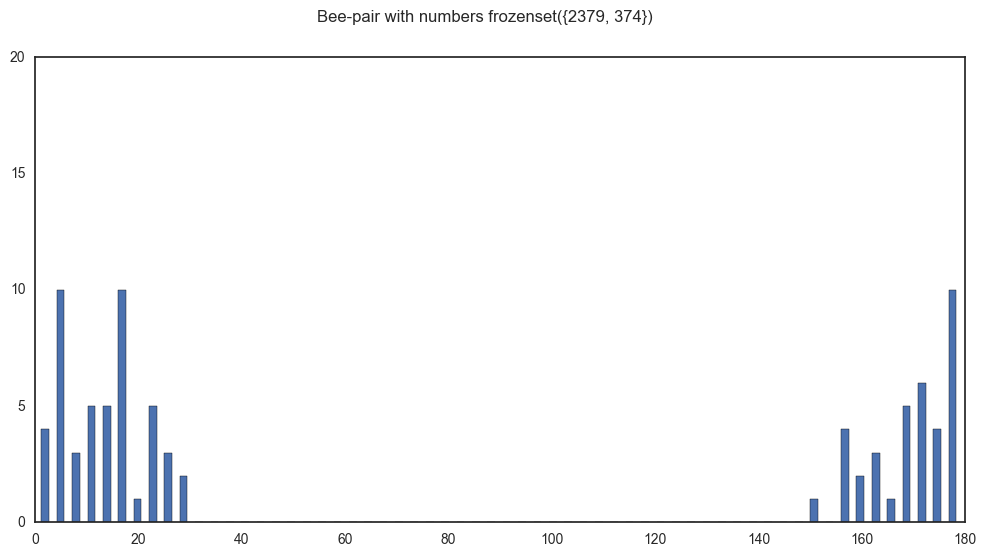

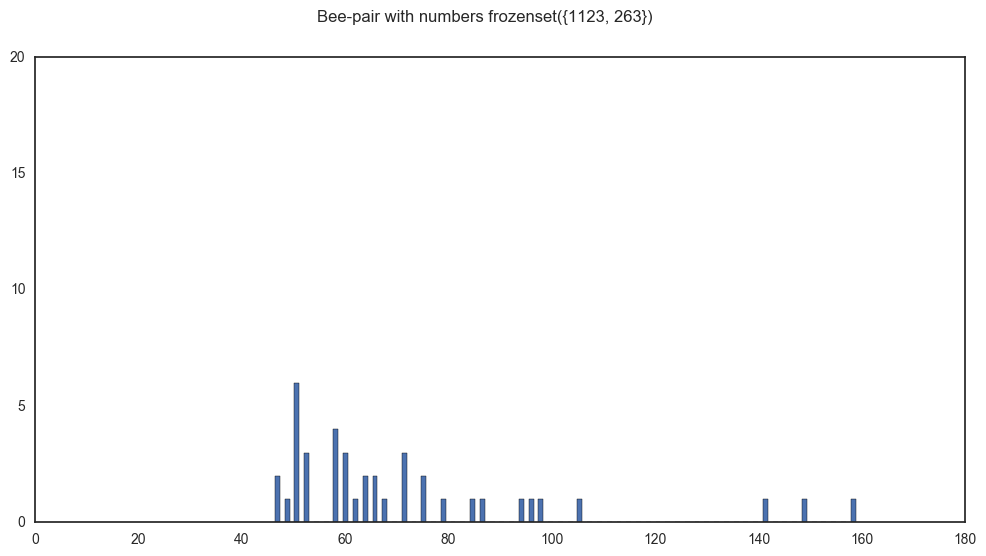

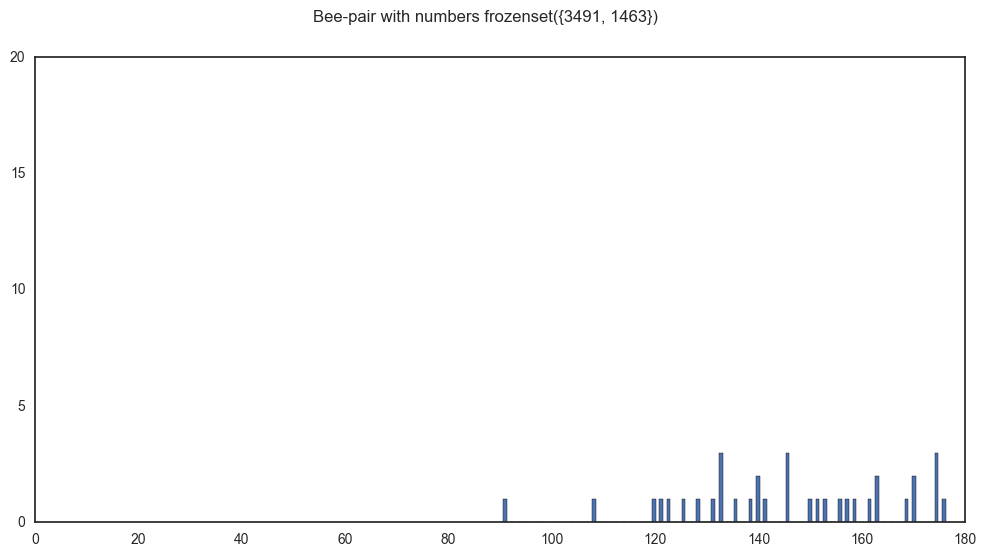

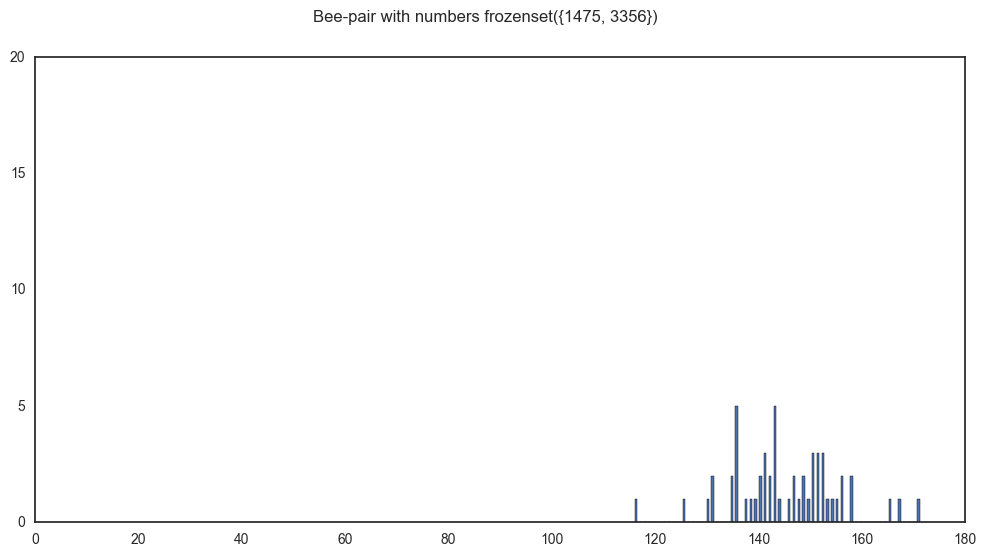

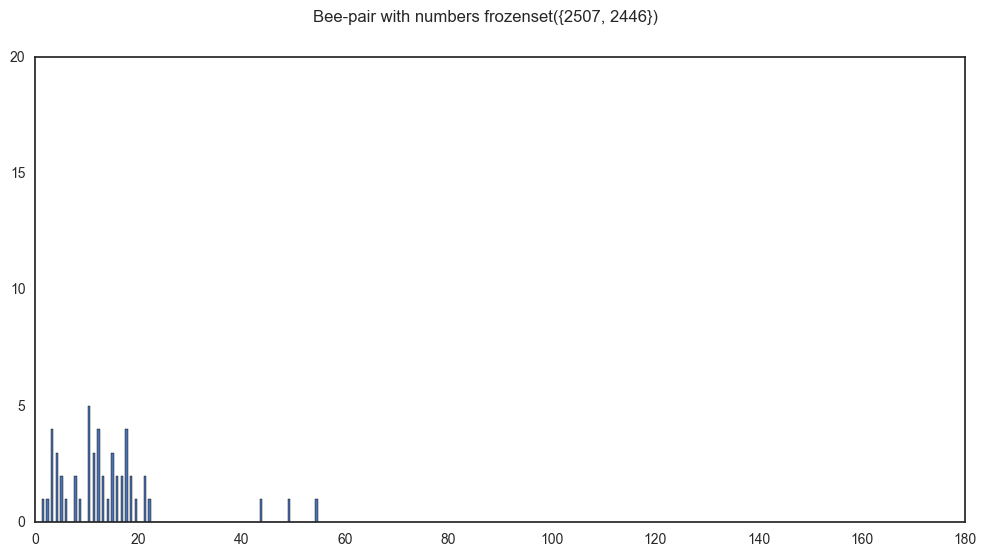

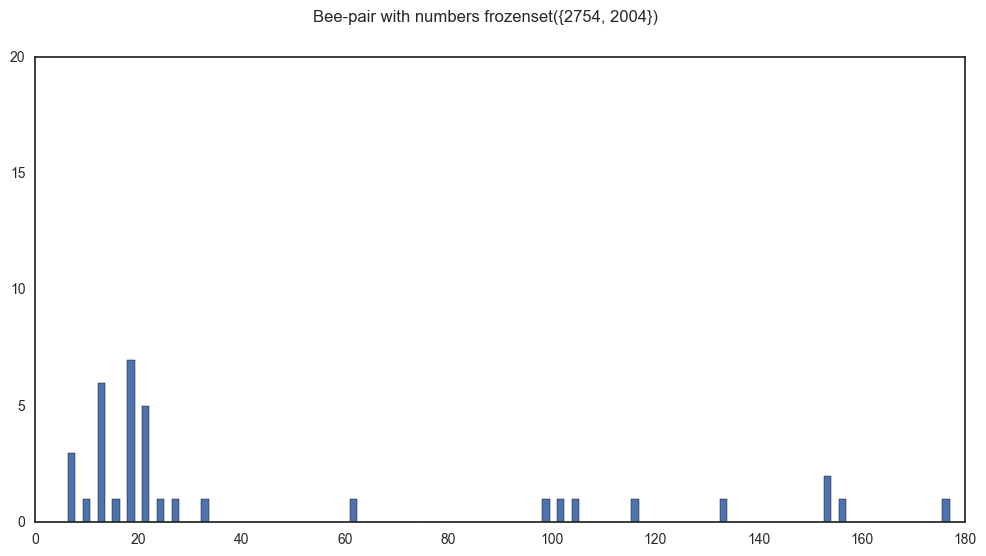

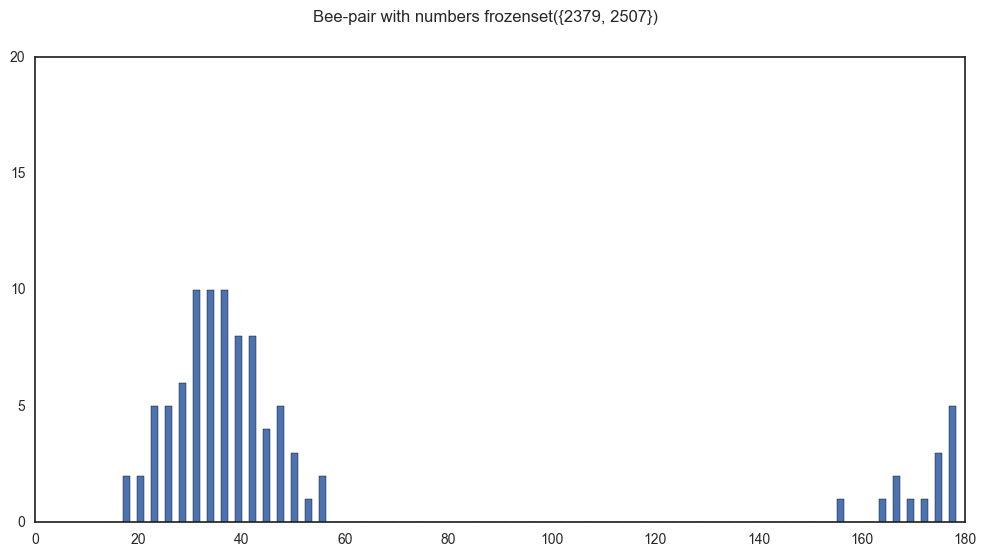

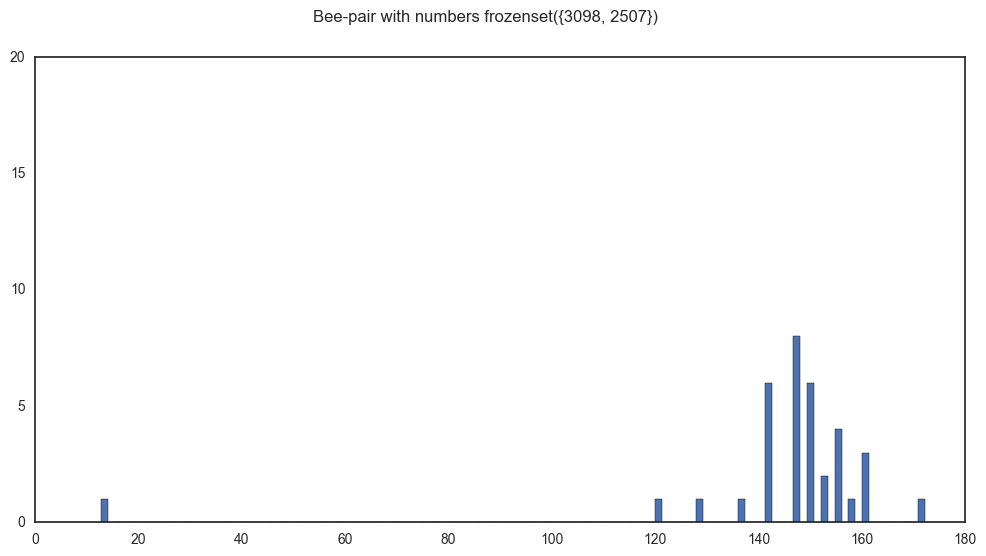

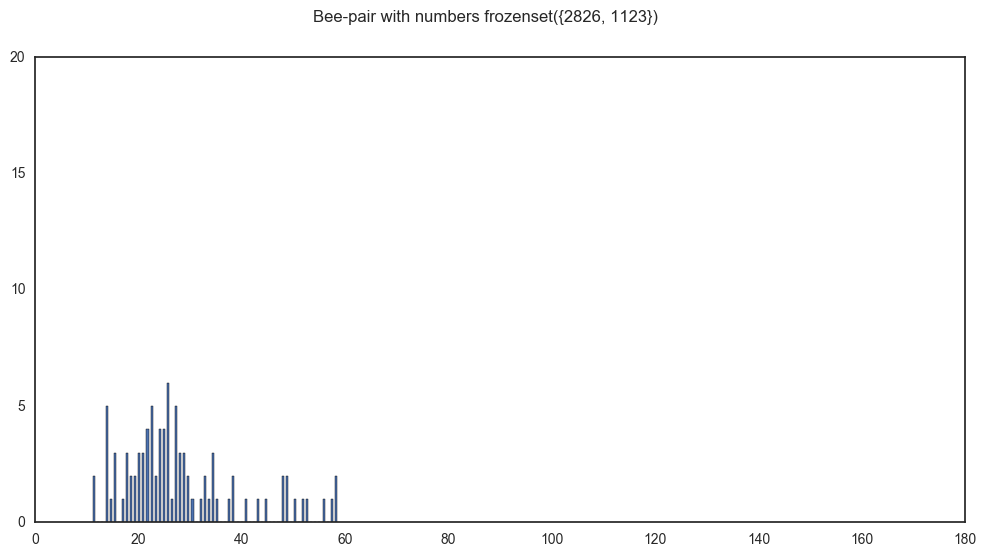

In [24]:
for p in pairs:
    interactions = [x[6] for x in bees if(x[0] in p and x[1] in p)]
    
    hist, bins = np.histogram(interactions, bins=60)
    width = 0.5* (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.xlim(0, 180)
    plt.ylim(0, 20)
    plt.suptitle('Bee-pair with numbers {}'.format(p), fontsize=12)
    plt.show()

## Interaction based on Timeslots (1024, 512, 256, 128, 64, 32, 16, 8, 4, 2)
* 32 -> 10.6 seconds ~11
* 16 -> 5.3 seconds ~5
* 8 -> 2.6 seconds ~3
* 4 -> 1.3 seconds

## Just make a network.

In [413]:
import networkx as nx
G=nx.Graph()

In [90]:
edges = [(x1,x2) for x1,x2,x3,x4 in bees ]

In [97]:
print(edges[0])
print(len(edges))

(1210, 233)
3227


In [99]:
# without edge weights
print(len(set(edges)))

948


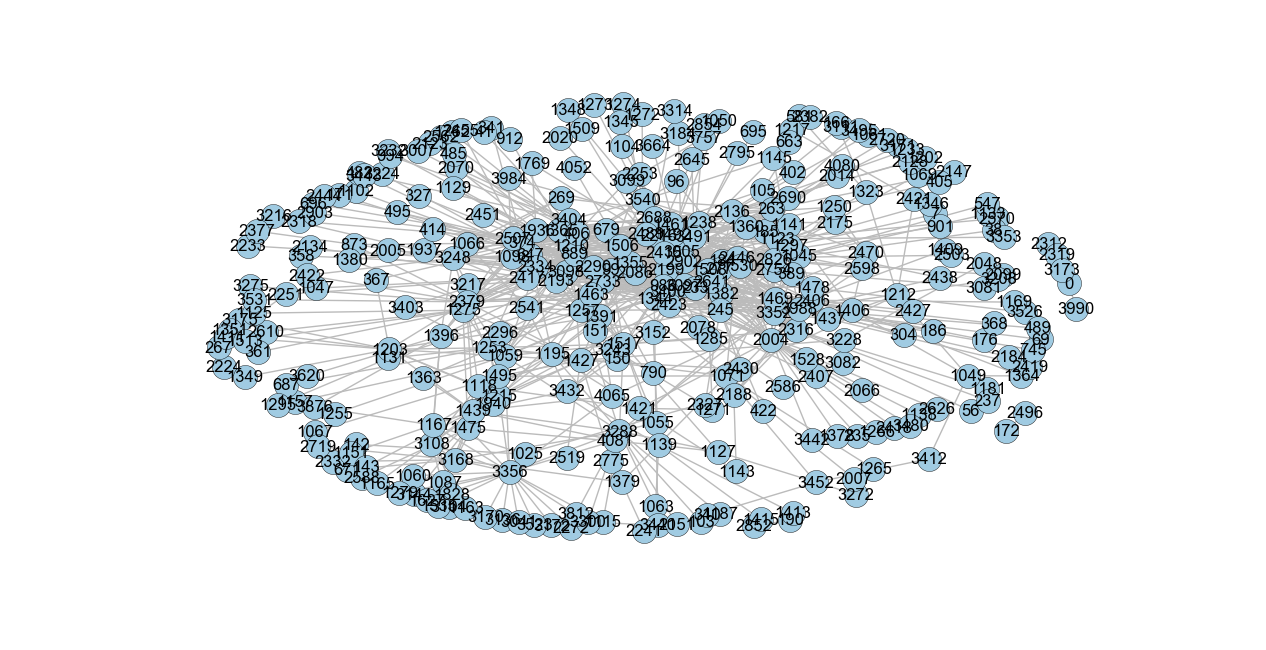

In [96]:
G.add_edges_from(edges)
pos=nx.spring_layout(G)
nx.draw(G,pos,node_color='#A0CBE2',edge_color='#BBBBBB',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.show()

In [100]:
print(nx.number_of_nodes(G))

329


In [101]:
nx.density(G)

0.015568240788790867

In [102]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 329\nNumber of edges: 840\nAverage degree:   5.1064'

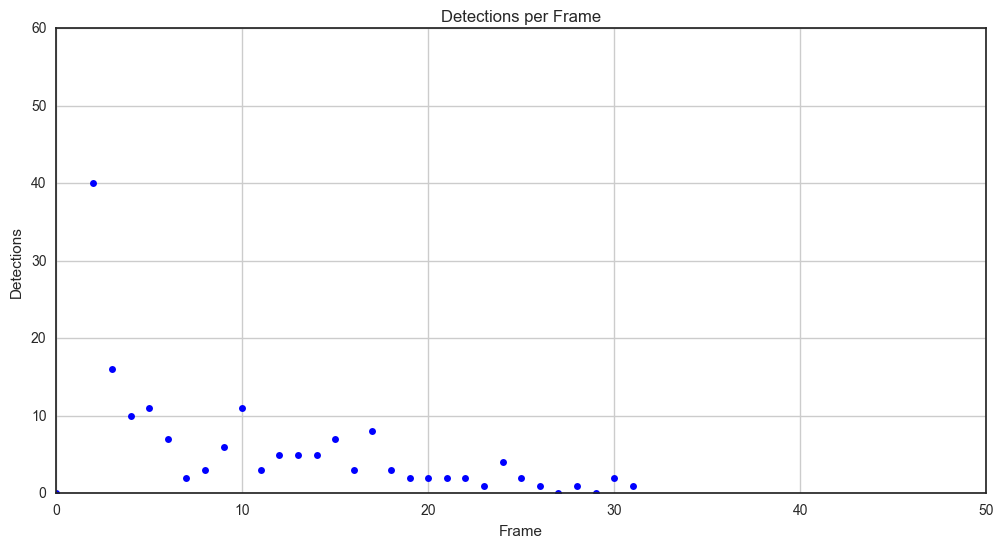

In [117]:
degrees = nx.degree_histogram(G)
# print(degrees)

plt.plot(degrees, 'bo', markersize=5)

plt.xlabel('Frame')
plt.ylabel('Detections')
plt.title('Detections per Frame')
plt.axis([0, 50, 0, 60])
plt.grid(True)

plt.show()

In [104]:
nx.k_clique_communities(G, 4)

<generator object k_clique_communities at 0x124187308>